### Import Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.datasets import SVHN
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
import sys
import os
import time
import logging

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Logger Setup

In [3]:
formatter = logging.Formatter('%(message)s')

def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""
    handler = logging.FileHandler(log_file)
    handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

In [4]:
def overlay_y_on_x(x, y, num_labels):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :num_labels] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

class FF_Linear(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.001)
        self.threshold = 2.0
        self.num_epochs = 1000
        
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))
        
    def train(self, x_pos, x_neg):
        g_pos = self.forward(x_pos).pow(2).mean(1)
        g_neg = self.forward(x_neg).pow(2).mean(1)
        self.opt.zero_grad()
        loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
        loss.backward()
        self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    # def train(self, x_pos, x_neg):
    #     e2e_start = torch.cuda.Event(enable_timing=True)
    #     e2e_end = torch.cuda.Event(enable_timing=True)
    #     gpu_compute_start = torch.cuda.Event(enable_timing=True)
    #     gpu_compute_end = torch.cuda.Event(enable_timing=True)
    #     e2e_start.record()
    #     for i in tqdm(range(self.num_epochs)):
    #         gpu_compute_start.record()
    #         g_pos = self.forward(x_pos).pow(2).mean(1)
    #         g_neg = self.forward(x_neg).pow(2).mean(1)
    #         # The following loss pushes pos (neg) samples to
    #         # values larger (smaller) than the self.threshold.
    #         loss = torch.log(1 + torch.exp(torch.cat([
    #             -g_pos + self.threshold,
    #             g_neg - self.threshold]))).mean()
    #         self.opt.zero_grad()
    #         # this backward just compute the derivative and hence
    #         # is not considered backpropagation.
    #         loss.backward()
    #         self.opt.step()
    #         gpu_compute_end.record()
    #         torch.cuda.synchronize()
    #         logger_gpu_compute.info(str(i) + "," + str(gpu_compute_start.elapsed_time(gpu_compute_end)) + "," + str(time.time() - reference_time))
    #     e2e_end.record()
    #     torch.cuda.synchronize()
    #     logger_e2e.info(str(e2e_start.elapsed_time(e2e_end)) + "," + str(time.time() - reference_time))
    #     return self.forward(x_pos).detach(), self.forward(x_neg).detach()

class Net(torch.nn.Module):

    def __init__(self, dims, num_labels):
        super().__init__()
        self.layers = []
        self.num_labels = num_labels
        for d in range(len(dims) - 1):
            self.layers += [FF_Linear(dims[d], dims[d + 1]).to(device)]

    def predict(self, x):
        goodness_per_label = []
        for label in range(self.num_labels):
            h = overlay_y_on_x(x, label, self.num_labels)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, input, label):
        x_pos = overlay_y_on_x(input, label, self.num_labels)
        rnd = torch.randperm(input.size(0))
        x_neg = overlay_y_on_x(input, label[rnd], self.num_labels)
        
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            # print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)


In [ ]:
def MNIST_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = MNIST('./data/MNIST/', train=True,
              download=True,
              transform=transform)
  test_data = MNIST('./data/MNIST/', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

mnist_train_data, mnist_test_data = MNIST_dataset()
print(mnist_train_data, mnist_test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/MNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
def FashionMNIST_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = FashionMNIST('./data/FashionMNIST/', train=True,
              download=True,
              transform=transform)
  test_data = FashionMNIST('./data/FashionMNIST/', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

fashion_train_data, fashion_test_data = FashionMNIST_dataset()
print(fashion_train_data, fashion_test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
def SVHN_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = SVHN('./data/SHVN/', split='train',
              download=True,
              transform=transform)
  test_data = SVHN('./data/SHVN/', split='test',
              download=True,
              transform=transform)
  return train_data, test_data

svhn_train_data, svhn_test_data = SVHN_dataset()
print(svhn_train_data, svhn_test_data)

Using downloaded and verified file: ./data/SHVN/train_32x32.mat
Using downloaded and verified file: ./data/SHVN/test_32x32.mat
Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data/SHVN/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data/SHVN/
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
def CIFAR10_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = CIFAR10('./data/CIFAR10', train=True,
              download=True,
              transform=transform)
  test_data = CIFAR10('./data/CIFAR10', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

cifar10_train_data, cifar10_test_data = CIFAR10_dataset()
print(cifar10_train_data, cifar10_test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/CIFAR10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
def CIFAR100_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = CIFAR100('./data/CIFAR100', train=True,
              download=True,
              transform=transform)
  test_data = CIFAR100('./data/CIFAR100', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

cifar100_train_data, cifar100_test_data = CIFAR100_dataset()
print(cifar100_train_data, cifar100_test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data/CIFAR100
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data/CIFAR100
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
# dataset = "MNIST"
# batch_size = 10000

# train_data, test_data = mnist_train_data, mnist_test_data
# num_labels = 10

# if not os.path.exists(dataset):
#       os.mkdir(dataset)

# logger_gpu_compute = setup_logger(dataset+"_logger_gpu_compute", os.path.join(dataset, "gpu_compute.csv"))
# logger_e2e = setup_logger(dataset+"_logger_e2e", os.path.join(dataset, "e2e.csv"))
# logger_gpu_compute.info('epoch,computetime_ms,log_time')
# logger_e2e.info('e2etime_ms,log_time')

# train_loader = DataLoader(train_data, batch_size=60000, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

# net = Net([784, 500, 500], num_labels=num_labels)

# net = net.to(device)
# epochs = 1000
# for e in range(epochs):
#   print(f"epoch e: {e + 1} of {epochs}")
#   correct = 0
  
#   for i, (input, label) in enumerate(tqdm(train_loader)):
#     input = input.to(device)
#     label = label.to(device)
#     # net.train(input, label)
    
#     correct += net.predict(input).eq(label).sum().item()
#   print(f"Train acc: {correct / len(train_data)}")
  
#   correct = 0

#   for i, (input, label) in enumerate(tqdm(test_loader)):
#     input = input.to(device)
#     label = label.to(device)
#     correct += net.predict(input).eq(label).sum().item()
#   print(f"Test acc: {correct / len(test_data)}")



# # for x, y in tqdm(test_loader):
# #   x_te, y_te = x_te.cuda(), y_te.cuda()

# #   print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

INFO:MNIST_logger_gpu_compute:epoch,computetime_ms,log_time
INFO:MNIST_logger_e2e:e2etime_ms,log_time


epoch e: 1 of 1000


100%|██████████| 1/1 [00:15<00:00, 15.27s/it]


Train acc: 0.060033333333333334


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Test acc: 0.0611
epoch e: 2 of 1000


  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
dataset = "MNIST"
batch_size = 256

train_data, test_data = mnist_train_data, mnist_test_data
num_labels = 10

if not os.path.exists(dataset):
      os.mkdir(dataset)

logger_gpu_compute = setup_logger(dataset+"_logger_gpu_compute", os.path.join(dataset, "gpu_compute.csv"))
logger_e2e = setup_logger(dataset+"_logger_e2e", os.path.join(dataset, "e2e.csv"))
logger_gpu_compute.info('epoch,computetime_ms,log_time')
logger_e2e.info('e2etime_ms,log_time')

train_loader = DataLoader(train_data, batch_size=60000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

net = Net([784, 500, 500], num_labels=num_labels)

net = net.to(device)
epochs = 1000

correct = 0
for i, (input, label) in enumerate(tqdm(train_loader)):
  for e in tqdm(range(epochs)):
    # print(f"epoch e: {e + 1} of {epochs}")
    
    for i, layer in enumerate(net.layers):
      
        input = input.to(device)
        label = label.to(device)
        net.train(input, label)
  correct += net.predict(input).eq(label).sum().item()
print(f"Train acc: {correct / len(train_data)}")

for i, (input, label) in enumerate(tqdm(test_loader)):
  input = input.to(device)
  label = label.to(device)
  correct += net.predict(input).eq(label).sum().item()
print(f"Test acc: {correct / len(test_data)}")



# for x, y in tqdm(test_loader):
#   x_te, y_te = x_te.cuda(), y_te.cuda()

#   print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

INFO:MNIST_logger_gpu_compute:epoch,computetime_ms,log_time
INFO:MNIST_logger_e2e:e2etime_ms,log_time
  0%|          | 0/1 [00:28<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
if __name__ == "__main__":
    reference_time = time.time()
    

    torch.manual_seed(1234)
    dataset = 'MNIST'
    # dataset = 'FashionMNIST'
    # dataset = 'CIFAR10'
    # dataset = 'CIFAR100'
    # dataset = 'SVHN'
    
    if not os.path.exists(dataset):
        os.mkdir(dataset)

    logger_gpu_compute = setup_logger(dataset+"_logger_gpu_compute", os.path.join(dataset, "gpu_compute.csv"))
    logger_e2e = setup_logger(dataset+"_logger_e2e", os.path.join(dataset, "e2e.csv"))
    logger_gpu_compute.info('epoch,computetime_ms,log_time')
    logger_e2e.info('e2etime_ms,log_time')

    if dataset == 'MNIST':
      train_loader, test_loader = MNIST_loaders()
    elif dataset == 'FashionMNIST':
      train_loader, test_loader = FashionMNIST_loaders()
    elif dataset == 'CIFAR10': 
      train_loader, test_loader = CIFAR10_loaders()
    elif dataset == 'CIFAR100':
      train_loader, test_loader = CIFAR100_loaders()
    elif dataset == 'SVHN':
      train_loader, test_loader = SVHN_loaders()
    else:
      print('Invalid dataset')
      exit()
    
    if dataset == 'MNIST' or dataset == 'FashionMNIST':
      net = Net([784, 500, 500]).to(device) # MNIST and FashionMNIST
    elif dataset == 'CIFAR10' or dataset == 'CIFAR100':
      net = Net([3072, 500, 500]).to(device) # CIFAR10, CIFAR100
    elif dataset == 'SVHN':
      net = Net([3072, 100, 100]).to(device) # SVHN
    else:
      print('Invalid dataset')
      exit()

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

### FashionMNIST Dataloader

In [ ]:
def FashionMNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        FashionMNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        FashionMNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = FashionMNIST_loaders()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### CIFAR10 Dataloader

In [ ]:
def CIFAR10_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.4914, 0.4822, 0.4465)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        CIFAR10('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        CIFAR10('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = CIFAR10_loaders()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


### CIFAR100 Dataloader

In [ ]:
def CIFAR100_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        CIFAR100('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        CIFAR100('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = CIFAR100_loaders()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


### SVHN Dataloader

In [ ]:
def SVHN_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        SVHN('./data/', split='train',
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        SVHN('./data/', split='test',
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = SVHN_loaders()

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

### Overlay Label on Image

In [ ]:
def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

### Compile Neural Network

In [ ]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000
        '''
        self.threshold = 1.5
        self.num_epochs = 2000
        '''
        
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    # def train(self, x_pos, x_neg):
    def train(self, x_pos, x_neg, logger_gpu_compute, logger_e2e, reference_time):
        e2e_start = torch.cuda.Event(enable_timing=True)
        e2e_end = torch.cuda.Event(enable_timing=True)
        gpu_compute_start = torch.cuda.Event(enable_timing=True)
        gpu_compute_end = torch.cuda.Event(enable_timing=True)
        e2e_start.record()
        for i in tqdm(range(self.num_epochs)):
            gpu_compute_start.record()
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
            gpu_compute_end.record()
            torch.cuda.synchronize()
            logger_gpu_compute.info(str(i) + "," + str(gpu_compute_start.elapsed_time(gpu_compute_end)) + "," + str(time.time() - reference_time))
        e2e_end.record()
        torch.cuda.synchronize()
        logger_e2e.info(str(e2e_start.elapsed_time(e2e_end)) + "," + str(time.time() - reference_time))
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### Define Neural Network Layers, Forward Pass, Train Method

### Method to Visualize Image

In [ ]:
def visualize_sample(data, dataset, name='', idx=0):
    if dataset == 'MNIST' or dataset == 'FashionMNIST':
      reshaped = data[idx].cpu().reshape(28, 28) # MNIST, FashionMNIST
    elif dataset == 'CIFAR10' or  dataset == 'CIFAR100' or dataset == 'SVHN':
      reshaped = np.transpose(data[idx].cpu().reshape((3, 32, 32)), (1, 2, 0)) # CIFAR10, CIFAR100, SVHN
    else:
      print('Invalid dataset')
      exit()
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

### main ( ) Method


##### Note: Toggle dataset variable

### Load Images, Create Positive and Negative Images by Overlaying True and Incorrect Labels, respectively

In [ ]:
    x, y = next(iter(train_loader))
    x, y = x.cuda(), y.cuda()
    x_pos = overlay_y_on_x(x, y)
    rnd = torch.randperm(x.size(0))
    x_neg = overlay_y_on_x(x, y[rnd])

### Visualize Original, Positive and Negative Images

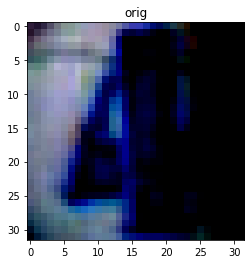

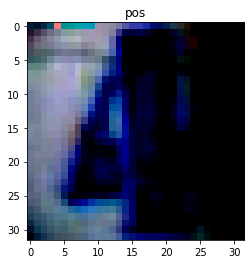

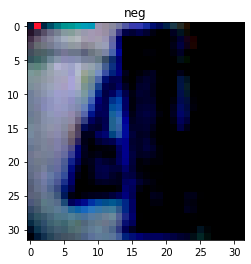

In [ ]:
    for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
            visualize_sample(data, dataset, name)

### Train and Test the Neural Network using FF Algorithm and Report Errors (rates)

In [ ]:
    # net.train(x_pos, x_neg)
    net.train(x_pos, x_neg, logger_gpu_compute, logger_e2e, reference_time)
    print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

    x_te, y_te = next(iter(test_loader))
    x_te, y_te = x_te.cuda(), y_te.cuda()

    print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

training layer 0 ...


  0%|          | 0/1000 [00:00<?, ?it/s]INFO:SVHN_logger_gpu_compute:0,0.0,40.64923453330994
INFO:SVHN_logger_gpu_compute:1,0.0,40.65427231788635
INFO:SVHN_logger_gpu_compute:2,0.0,40.658936977386475
INFO:SVHN_logger_gpu_compute:3,0.0,40.66567611694336
INFO:SVHN_logger_gpu_compute:4,0.0,40.66969418525696
INFO:SVHN_logger_gpu_compute:5,0.0,40.676541328430176
INFO:SVHN_logger_gpu_compute:6,0.0,40.68043780326843
INFO:SVHN_logger_gpu_compute:7,0.0,40.685633420944214
INFO:SVHN_logger_gpu_compute:8,0.0,40.690322160720825
INFO:SVHN_logger_gpu_compute:9,0.0,40.694716930389404
INFO:SVHN_logger_gpu_compute:10,0.0,40.699551820755005
INFO:SVHN_logger_gpu_compute:11,0.0,40.70369243621826
INFO:SVHN_logger_gpu_compute:12,0.0,40.70807337760925
INFO:SVHN_logger_gpu_compute:13,0.0,40.7127583026886
INFO:SVHN_logger_gpu_compute:14,0.0,40.731365442276
INFO:SVHN_logger_gpu_compute:15,0.0,40.81917190551758
  2%|▏         | 16/1000 [00:00<00:11, 87.24it/s]INFO:SVHN_logger_gpu_compute:16,0.0,40.90522861480713


training layer 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]INFO:SVHN_logger_gpu_compute:0,0.0,120.44135689735413
INFO:SVHN_logger_gpu_compute:1,0.0,120.4455053806305
INFO:SVHN_logger_gpu_compute:2,0.0,120.45148134231567
INFO:SVHN_logger_gpu_compute:3,0.0,120.45561194419861
INFO:SVHN_logger_gpu_compute:4,0.0,120.46151041984558
INFO:SVHN_logger_gpu_compute:5,0.0,120.46823620796204
INFO:SVHN_logger_gpu_compute:6,0.0,120.4723858833313
INFO:SVHN_logger_gpu_compute:7,0.0,120.47693181037903
INFO:SVHN_logger_gpu_compute:8,0.0,120.48191523551941
INFO:SVHN_logger_gpu_compute:9,0.0,120.4865608215332
INFO:SVHN_logger_gpu_compute:10,0.0,120.49136662483215
INFO:SVHN_logger_gpu_compute:11,0.0,120.49625420570374
INFO:SVHN_logger_gpu_compute:12,0.0,120.50130772590637
INFO:SVHN_logger_gpu_compute:13,0.0,120.50606870651245
INFO:SVHN_logger_gpu_compute:14,0.0,120.51355075836182
INFO:SVHN_logger_gpu_compute:15,0.0,120.5186493396759
INFO:SVHN_logger_gpu_compute:16,0.0,120.52379059791565
INFO:SVHN_logger_gpu_compute:17,0.0,120

train error: 0.3906499743461609
test error: 0.4147000312805176


In [ ]:
!zip -r /content/MNIST_logs.zip /content/MNIST/
!zip -r /content/FashionMNIST_logs.zip /content/FashionMNIST/
!zip -r /content/CIFAR10_logs.zip /content/CIFAR10/
!zip -r /content/CIFAR100_logs.zip /content/CIFAR100/
!zip -r /content/SVHN_logs.zip /content/SVHN/

  adding: content/MNIST/ (stored 0%)
  adding: content/MNIST/gpu_compute.csv (deflated 57%)
  adding: content/MNIST/e2e.csv (deflated 14%)
  adding: content/FashionMNIST/ (stored 0%)
  adding: content/FashionMNIST/gpu_compute.csv (deflated 57%)
  adding: content/FashionMNIST/e2e.csv (deflated 13%)
  adding: content/CIFAR10/ (stored 0%)
  adding: content/CIFAR10/gpu_compute.csv (deflated 57%)
  adding: content/CIFAR10/e2e.csv (deflated 13%)
  adding: content/CIFAR100/ (stored 0%)
  adding: content/CIFAR100/gpu_compute.csv (deflated 57%)
  adding: content/CIFAR100/e2e.csv (deflated 14%)
  adding: content/SVHN/ (stored 0%)
  adding: content/SVHN/gpu_compute.csv (deflated 58%)
  adding: content/SVHN/e2e.csv (deflated 15%)
